In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from sklearn import preprocessing
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import time
import scipy.io as sc
from sklearn.metrics import mean_squared_error, r2_score

# hyperparameters to be modified
WINDOW_SIZE = 12
LEARNING_RATE = 0.001
BATCH_SIZE = 7*24
LSTM_NODES = 64

# code is taken from this resource: https://www.youtube.com/watch?v=c0k-YLQGKjY
# and modified to suit my own dataset

In [126]:
# download the data
f = sc.loadmat('data_new.mat')
vals = f['data_new'][0,0]
keys = f['data_new'][0,0].dtype.descr
f['data_new'][0,0]["Y"].shape

# get the values from the struct
data = {}
for i in range(len(keys)-1):
    key = keys[i][0]
    data[str(key)] = vals[key]

datafrm = {"Temperature": data["X"][0,:].reshape(-1), "Turbidity": data["X"][1,:].reshape(-1), "Chlorophyll": data["X"][2,:].reshape(-1), "TargetChlorophyll": data["Y"].reshape(-1)}
data = pd.DataFrame(data=datafrm)
'''
# visualize the data
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
plt.subplot(3,1,1)
plt.plot(data["Temperature"],c='black')
plt.title("Temperature")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(data["Turbidity"],c='black')
plt.title("Turbidity")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(data["Chlorophyll"],c='black')
plt.title("Chlorophyll")

plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()
print(data.shape)'''

'\n# visualize the data\nplt.figure(figsize=(15,5))\nplt.gca().xaxis.set_major_formatter(mdates.DateFormatter(\'%Y-%m-%d\'))\nplt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))\nplt.subplot(3,1,1)\nplt.plot(data["Temperature"],c=\'black\')\nplt.title("Temperature")\nplt.grid(True)\n\nplt.subplot(3,1,2)\nplt.plot(data["Turbidity"],c=\'black\')\nplt.title("Turbidity")\nplt.grid(True)\n\nplt.subplot(3,1,3)\nplt.plot(data["Chlorophyll"],c=\'black\')\nplt.title("Chlorophyll")\n\nplt.gcf().autofmt_xdate()\nplt.grid(True)\nplt.show()\nprint(data.shape)'

In [127]:
# split the data into train and test partitions, use 94% first samples as test data and rest as train data
Tp = 15977 # test samples
Tv = 850 # number of validation samples
values = data.values.astype(np.float32)
train,test = values[0:Tp,:], values[Tp:,:]

# normalize the data, use train set normalization for test set
scaler = preprocessing.StandardScaler()
train_scaler = scaler.fit(train)
data_norm = train_scaler.transform(values).reshape(-1,4)

#data_norm = pd.DataFrame(data_norm, columns=["Value"])
# visualize the data again with test and training samples separated
index = data.index.values
'''
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=500))
plt.subplot(3,1,1)
plt.plot(index[0:Tp],data_norm[:Tp,0],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,0],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,0],c='orange',alpha=0.7)
plt.title("Normalized Temperature")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(index[0:Tp],data_norm[:Tp,1],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,1],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,1],c='orange',alpha=0.7)
plt.title("Normalized Turbidity")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(index[0:Tp],data_norm[:Tp,2],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,2],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,2],c='orange',alpha=0.7)
plt.legend(['Train','Validation', 'Test'])
plt.title("Normalized Chlorophyll")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()'''


'\nplt.figure(figsize=(15,5))\nplt.gca().xaxis.set_major_formatter(mdates.DateFormatter(\'%Y-%m-%d\'))\nplt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=500))\nplt.subplot(3,1,1)\nplt.plot(index[0:Tp],data_norm[:Tp,0],c=\'blue\')\nplt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,0],c=\'green\')\nplt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,0],c=\'orange\',alpha=0.7)\nplt.title("Normalized Temperature")\nplt.grid(True)\n\nplt.subplot(3,1,2)\nplt.plot(index[0:Tp],data_norm[:Tp,1],c=\'blue\')\nplt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,1],c=\'green\')\nplt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,1],c=\'orange\',alpha=0.7)\nplt.title("Normalized Turbidity")\nplt.grid(True)\n\nplt.subplot(3,1,3)\nplt.plot(index[0:Tp],data_norm[:Tp,2],c=\'blue\')\nplt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,2],c=\'green\')\nplt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,2],c=\'orange\',alpha=0.7)\nplt.legend([\'Train\',\'Validation\', \'Test\'])\nplt.title("Normalized Chlorophyll")\nplt.gcf().autofmt_xda

In [128]:
# sliding window
def df_to_X_y(df, window_size=5):
  #print(df.shape)
  X = []
  y = []
  # indices for X data
  xindex = [0,1,2]
  Xdata= df[:,xindex]
  #print(Xdata.shape)
  # index for y data
  Ydata = df[:,3]
  #print(Ydata.shape)
  # construct the dataset
  for i in range(len(df)-window_size):
    row = [[a] for a in Xdata[i:i+window_size]]
    X.append(row)
    label = Ydata[i+window_size-1]
    y.append(label)
  return np.array(X), np.array(y)


X, y = df_to_X_y(data_norm, WINDOW_SIZE)
print(X.shape, y.shape)

# get rid of extra dimensions (1)
X_train, y_train = X[:Tp].squeeze(), y[:Tp]
X_val, y_val = X[Tp:Tp+Tv].squeeze(), y[Tp:Tp+Tv]
X_test, y_test = X[Tp+Tv:].squeeze(), y[Tp+Tv:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(16985, 12, 1, 3) (16985,)
(15977, 12, 3) (15977,)
(158, 12, 3) (158,)


In [129]:
# define the LSTM model
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.InputLayer((WINDOW_SIZE, X_train.shape[2])))
lstm_model.add(tf.keras.layers.LSTM(LSTM_NODES))
lstm_model.add(tf.keras.layers.Dense(8, 'relu'))
lstm_model.add(tf.keras.layers.Dense(1, 'linear'))

# check point so that only the model with smalles validation loss is saved
cp = ModelCheckpoint('lstm_model/', save_best_only=True)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), metrics=[tf.keras.metrics.MeanSquaredError()])

# train the model and time it
start = time.time()
lstm_model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            callbacks=[cp],
            batch_size = BATCH_SIZE)
end = time.time()
print("Training time " + str(end-start))

lstm_model_best = load_model('lstm_model/')


Epoch 1/50
89/96 [==========================>...] - ETA: 0s - loss: 0.2485 - mean_squared_error: 0.2485INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


96/96 [==============================] - 3s 20ms/step - loss: 0.2345 - mean_squared_error: 0.2345 - val_loss: 1.1876e-04 - val_mean_squared_error: 1.1876e-04
Epoch 2/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0936 - mean_squared_error: 0.0936 - val_loss: 8.2258e-04 - val_mean_squared_error: 8.2258e-04
Epoch 3/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0827 - mean_squared_error: 0.0827 - val_loss: 2.1670e-04 - val_mean_squared_error: 2.1670e-04
Epoch 4/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0777 - mean_squared_error: 0.0777 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - val_loss: 1.4483e-04 - val_mean_squared_error: 1.4483e-04
Epoch 6/50
89/96 [==========================>...] - ETA: 0s - loss: 0.0760 - mean_squared_error: 0.0760INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


96/96 [==============================] - 2s 18ms/step - loss: 0.0727 - mean_squared_error: 0.0727 - val_loss: 6.9358e-05 - val_mean_squared_error: 6.9358e-05
Epoch 7/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 9.6617e-05 - val_mean_squared_error: 9.6617e-05
Epoch 8/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 1.1684e-04 - val_mean_squared_error: 1.1684e-04
Epoch 9/50
95/96 [============================>.] - ETA: 0s - loss: 0.0679 - mean_squared_error: 0.0679INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets


96/96 [==============================] - 2s 18ms/step - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 5.6640e-05 - val_mean_squared_error: 5.6640e-05
Epoch 10/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 1.2331e-04 - val_mean_squared_error: 1.2331e-04
Epoch 11/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0655 - mean_squared_error: 0.0655 - val_loss: 1.2760e-04 - val_mean_squared_error: 1.2760e-04
Epoch 12/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 5.8660e-04 - val_mean_squared_error: 5.8660e-04
Epoch 13/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 5.0572e-04 - val_mean_squared_error: 5.0572e-04
Epoch 14/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 9.0208e-05 - val_mean_squared_error: 9.0208e-

INFO:tensorflow:Assets written to: lstm_model/assets


96/96 [==============================] - 2s 18ms/step - loss: 0.0613 - mean_squared_error: 0.0613 - val_loss: 2.3982e-05 - val_mean_squared_error: 2.3982e-05
Epoch 16/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 17/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - val_loss: 2.9832e-04 - val_mean_squared_error: 2.9832e-04
Epoch 18/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 7.1832e-05 - val_mean_squared_error: 7.1832e-05
Epoch 19/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0580 - mean_squared_error: 0.0580 - val_loss: 1.1568e-04 - val_mean_squared_error: 1.1568e-04
Epoch 20/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 1.7969e-04 - val_mean_squared_error: 1.7969e-04
Epoch

INFO:tensorflow:Assets written to: lstm_model/assets


96/96 [==============================] - 2s 20ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 2.3716e-05 - val_mean_squared_error: 2.3716e-05
Epoch 48/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 3.0097e-04 - val_mean_squared_error: 3.0097e-04
Epoch 49/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 7.3213e-04 - val_mean_squared_error: 7.3213e-04
Epoch 50/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 2.5525e-04 - val_mean_squared_error: 2.5525e-04
Training time 42.37539196014404


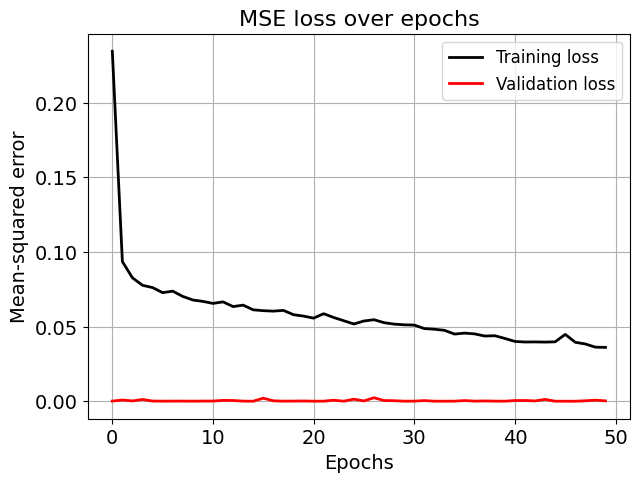

In [130]:
#lstm_model.summary()
# visualize the losses over the epochs
plt.figure(figsize=(7,5))
plt.title("MSE loss over epochs",fontsize=16)
plt.plot((lstm_model.history.history['loss']),c='k',lw=2, label="Training loss")
plt.plot((lstm_model.history.history['val_loss']),c='r',lw=2, label="Validation loss")
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.legend(fontsize=12)
plt.ylabel("Mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [131]:
# test the model
validation_target = y_test
validation_predictions = []
# use last value before test partition as the input parameter for the model
last_x = X_val[-1,:,:]

# help index so we can get the correct temperature and turbidity values for input sample
testInd = 0
while len(validation_predictions) < len(validation_target):
  # predict
  p = lstm_model_best.predict(last_x.reshape(1,WINDOW_SIZE,3), verbose=1)[0,0]
  validation_predictions.append(p)
  # add the predicted chlorophyll value to the chlorophyll value with actual temperature and turbidity values
  last_x = np.roll(last_x, -1, axis=0)
  last_x[-1,0] = X_test[testInd,-1,0]
  last_x[-1,1] = X_test[testInd,-1,1]
  last_x[-1,2] = p
  testInd = testInd + 1




1/1 [==============================] - 0s 10ms/step


In [132]:

# Evaluate the model performance
mse = mean_squared_error(validation_target, validation_predictions)
r2 = r2_score(validation_target, validation_predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.016108352690935135
R-squared: -0.42561413664016845


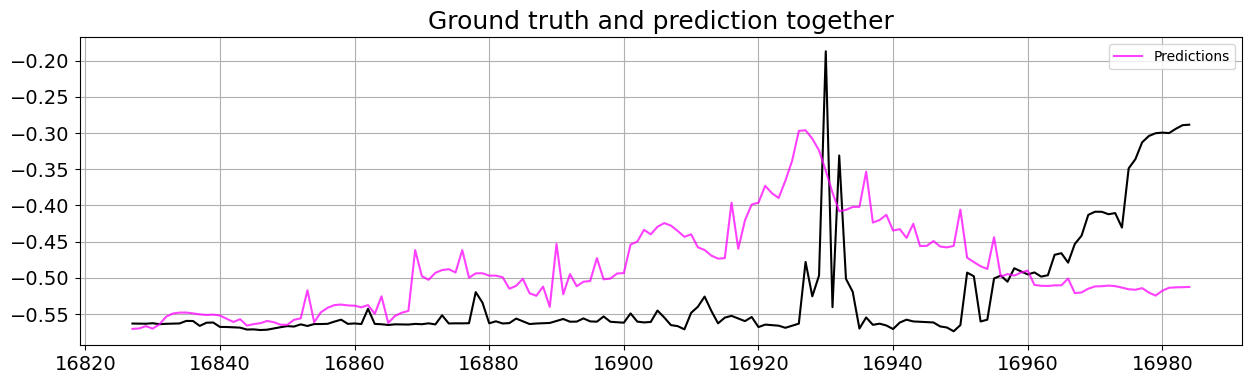

In [139]:
# visualize the ground  truth and the prediction together
index = data.index.values
train_index = index[:Tp]
val_index = index[Tp:Tp+Tv]
test_index = index[Tp+Tv:-WINDOW_SIZE]

plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)

plt.plot(test_index, data_norm[test_index,-1],c='black')
plt.plot(test_index, validation_predictions, c='magenta',alpha=0.75, label="Predictions")

plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [134]:
'''import visualkeras
model = lstm_model
visualkeras.layered_view(model).show()'''

'import visualkeras\nmodel = lstm_model\nvisualkeras.layered_view(model).show()'